# Task 2 Classification on the Telco-churn dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #ignore all the warnings

In [2]:
#import dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

## 2.1

To split the continuous varibales and categorical variables, I change all categorical varaibles to object, and all continuous variables to int or float.

In [5]:
data.loc[:,'SeniorCitizen'] = data.loc[:,'SeniorCitizen'].astype('object')
data.loc[:,'TotalCharges'] = pd.to_numeric(data.loc[:,'TotalCharges'],errors= 'coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(1), o

The continuous varaibles are 
- tenure   
- MonthlyCharges   
- TotalCharges

the target is 
- Churn    

### Visualize the univariate distribution of each continuous feature

To visualize the univariate distribution of each continuous feature, I draw histgram using seaborn.distplot.

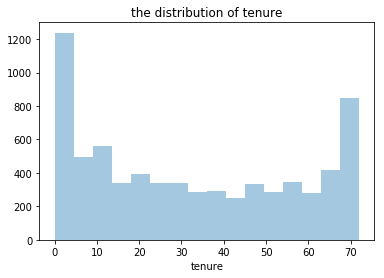

In [6]:
sns.distplot(data.loc[:,'tenure'],kde = False,rug = False)
#kde: Whether to plot a gaussian kernel density estimate. rug: Whether to draw a rugplot on the support axis.
_ = plt.title("the distribution of tenure")

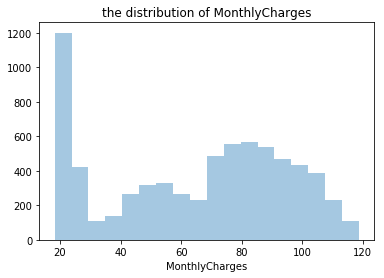

In [7]:
sns.distplot(data.loc[:,'MonthlyCharges'],kde = False,rug = False)
_ = plt.title("the distribution of MonthlyCharges")

For TotalCharges, there is missing values. When visualize this feature, I just drop the missing value (NaN).

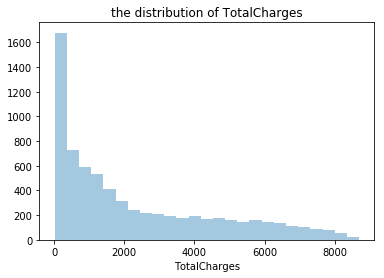

In [8]:
sns.distplot(data.loc[:,'TotalCharges'].dropna(),kde = False,rug = False)
_ = plt.title("the distribution of TotalCharges")

### Visualize the distribution of the target.

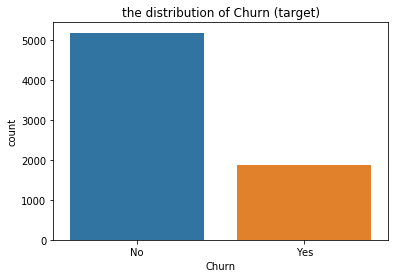

In [9]:
sns.countplot(data.loc[:,'Churn'])
_ =  plt.title("the distribution of Churn (target)")

## 2.2

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

Since CustomerID are just ID, a unique feature of data, I think it makes no difference in prediction and I just **drop this column**.      
Besides, in target "Churn", there are about 70% data is "No". I think it is a little imbalanced, so I use stratify in train_test_split.

In [11]:
#Not include CustomerID
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)  

In [12]:
categorical = X_train.dtypes == object

### Without standardizing the continuous variables

In [13]:
from sklearn.pipeline import Pipeline
categorical_transfomer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),('scaler',OneHotEncoder(handle_unknown = 'ignore'))])
preprocess = make_column_transformer((categorical_transfomer,categorical),(SimpleImputer(strategy = 'median'),~categorical))


In [14]:
score_noscale = {}
#Logistic Regression
model = make_pipeline(preprocess,LogisticRegression())
score_noscale['logistic'] = cross_val_score(model,X_train,y_train,cv = 10).mean()
#linear support vector machines
model = make_pipeline(preprocess,LinearSVC())
score_noscale['linearSVC'] = cross_val_score(model,X_train,y_train,cv = 10).mean()
#nearest centroids
model = make_pipeline(preprocess,NearestCentroid())
score_noscale['nearestcentroids'] = cross_val_score(model,X_train,y_train,cv = 10).mean()

In [15]:
score_noscale

{'logistic': 0.803510048959248,
 'linearSVC': 0.6413810691516568,
 'nearestcentroids': 0.5122863667518069}

The results shows that logistic regression performs much better than the others, and the second one is linearSVC, last one is nearest centroids. 

### Standardizing the continuous variables

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
continuous_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
categorical_transfomer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),('scaler',OneHotEncoder(handle_unknown = 'ignore'))])
                               

In [18]:
preprocess = make_column_transformer((categorical_transfomer,categorical),(continuous_transformer,~categorical))
score_scaled = {}

In [19]:
#Logistic Regression
lr_model = make_pipeline(preprocess,LogisticRegression())
score_scaled['logisticregression'] = cross_val_score(lr_model,X_train,y_train,cv = 10).mean()
#linear support vector machines
linearSVC_model = make_pipeline(preprocess,LinearSVC())
score_scaled['linearSVC'] = cross_val_score(linearSVC_model,X_train,y_train,cv = 10).mean()
#nearest centroids
nearestcentroids_model = make_pipeline(preprocess,NearestCentroid())
score_scaled['nearestcentroids'] = cross_val_score(nearestcentroids_model,X_train,y_train,cv = 10).mean()

In [20]:
score_scaled

{'logisticregression': 0.8045684732585794,
 'linearSVC': 0.805203620464605,
 'nearestcentroids': 0.7312272680103622}

Generally, scaling the continuous variables with StandardScaler improve the result.    
For logistic regression, the result doesn't improve a lot, just 0.001.   
For linearSVC, the score increases about 0.16 and makes linearSVC achieve the similar score with logistic regression, even better than logistic regression.     
For nearest centroids, the score increases about 0.2; the result improves most among these three models, but it is still the worst one.

## 2.3

In [21]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

For logistic regression, I will tune the parameter C.

In [22]:
param_grid = {'logisticregression__C':np.logspace(-3,3,13)}
grid_lr = GridSearchCV(lr_model,param_grid,cv=10)
grid_lr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strateg...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': array([1.00000e-03, 3.16228e-03, 1.00000e-02, 3.16228e-02, 1.00000e-01,
       3.16228e-01, 1.00000e+00, 3.16228e+00, 1.00000e+01, 3.16228e+01,
       1.00000e+02, 3.16228e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
print (grid_lr.best_params_)
print (grid_lr.best_score_)

{'logisticregression__C': 100.0}
0.8062738448495125


The score increases 0.002 with C = 100.

In [24]:
res_lr = pd.pivot_table(pd.DataFrame(grid_lr.cv_results_),values= 'mean_test_score',index='param_logisticregression__C')
res_lr

,mean_test_score
param_logisticregression__C,
0.001000,0.785502
0.003162,0.801399
0.010000,0.806062
0.031623,0.803730
0.100000,0.802671
0.316228,0.802883
1.000000,0.804578
3.162278,0.805850
10.000000,0.806062


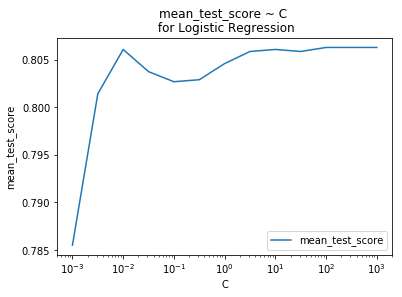

In [56]:
ax1 = sns.lineplot(data = res_lr)
ax1.set_xscale('log')
ax1.set_title('mean_test_score ~ C \n for Logistic Regression')
_ = plt.xlabel('C')
_ = plt.ylabel('mean_test_score')

### Linear support vector machine

For linear suppport vector machine, I will tune the parameter C.

In [26]:
param_grid = {'linearsvc__C':np.logspace(-3,3,13)}
grid_lnearsvc = GridSearchCV(linearSVC_model,param_grid,cv=10)
grid_lnearsvc.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strateg...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'linearsvc__C': array([1.00000e-03, 3.16228e-03, 1.00000e-02, 3.16228e-02, 1.00000e-01,
       3.16228e-01, 1.00000e+00, 3.16228e+00, 1.00000e+01, 3.16228e+01,
       1.00000e+02, 3.16228e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
print (grid_lnearsvc.best_params_)
print (grid_lnearsvc.best_score_)

{'linearsvc__C': 3.1622776601683795}
0.8058499364137346


In [28]:
res_linearsvc = pd.pivot_table(pd.DataFrame(grid_lnearsvc.cv_results_),values= 'mean_test_score',index='param_linearsvc__C')
res_linearsvc

,mean_test_score
param_linearsvc__C,
0.001000,0.803306
0.003162,0.803306
0.010000,0.803730
0.031623,0.803942
0.100000,0.803518
0.316228,0.803730
1.000000,0.805214
3.162278,0.805850
10.000000,0.802035


The result improves 0.0006 with C = 3.162.

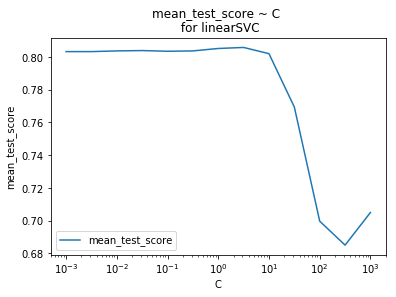

In [58]:
ax2 = sns.lineplot(data = res_linearsvc)
ax2.set_xscale('log')
ax2.set_title('mean_test_score ~ C \n for linearSVC')
_ = plt.xlabel('C')
_ = plt.ylabel('mean_test_score')

### Nearest Centroids

For Nearest Centroids, I will tune the parameter shrink_threshold.

In [30]:
#to tune this parameter, mmodify the pipeline and change onehotencoder(sparse = True) to onehotencoder(sparse = False)
continuous_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
categorical_transfomer_dense = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),('scaler',OneHotEncoder(sparse = False, handle_unknown = 'ignore'))])
preprocess_dense = make_column_transformer((categorical_transfomer_dense,categorical),(continuous_transformer,~categorical))
nearestcentroids_model_dense = make_pipeline(preprocess_dense,NearestCentroid())

In [31]:
param_grid = {'nearestcentroid__shrink_threshold':np.logspace(-3,3,13)}
grid_nearestcentroid = GridSearchCV(nearestcentroids_model_dense,param_grid,cv=10)
grid_nearestcentroid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strateg...ue
dtype: bool)])), ('nearestcentroid', NearestCentroid(metric='euclidean', shrink_threshold=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'nearestcentroid__shrink_threshold': array([1.00000e-03, 3.16228e-03, 1.00000e-02, 3.16228e-02, 1.00000e-01,
       3.16228e-01, 1.00000e+00, 3.16228e+00, 1.00000e+01, 3.16228e+01,
       1.00000e+02, 3.16228e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
print (grid_nearestcentroid.best_params_)
print (grid_nearestcentroid.best_score_)

{'nearestcentroid__shrink_threshold': 31.622776601683793}
0.7346333192030522


In [33]:
res_nearestcentroid = pd.pivot_table(pd.DataFrame(grid_nearestcentroid.cv_results_),values= 'mean_test_score',index='param_nearestcentroid__shrink_threshold')
res_nearestcentroid

,mean_test_score
param_nearestcentroid__shrink_threshold,
0.001000,0.731242
0.003162,0.731242
0.010000,0.731030
0.031623,0.731030
0.100000,0.730606
0.316228,0.729970
1.000000,0.728275
3.162278,0.720856
10.000000,0.647308


The result improves with the score increasing 0.003 when shrink threshold equals about 31.62.

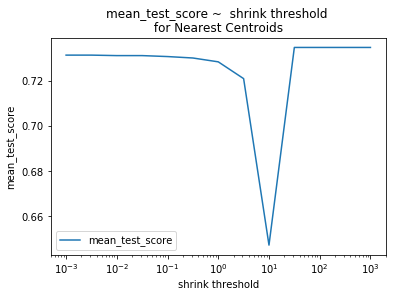

In [59]:
ax3 = sns.lineplot(data = res_nearestcentroid)
ax3.set_xscale('log')
ax3.set_title('mean_test_score ~  shrink threshold \n for Nearest Centroids ')
_ = plt.xlabel('shrink threshold')
_ = plt.ylabel('mean_test_score')

## 2.4

### Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling

In [35]:
from sklearn.model_selection import KFold

In [36]:
kfold = KFold(n_splits=10, shuffle=True)

**Logistic Regression**

In [37]:
param_grid_new = {'logisticregression__C':np.logspace(-3,3,13)}
grid_lr_new = GridSearchCV(lr_model,param_grid_new,cv=kfold)
grid_lr_new.fit(X_train,y_train)
print (grid_lr_new.best_params_)
print (grid_lr_new.best_score_)

{'logisticregression__C': 0.01}
0.8060618906316236


**Linear SVC**

In [38]:
param_grid_new = {'linearsvc__C':np.logspace(-3,3,13)}
grid_lnearsvc_new = GridSearchCV(linearSVC_model,param_grid_new,cv=kfold)
grid_lnearsvc_new.fit(X_train,y_train)
print (grid_lnearsvc_new.best_params_)
print (grid_lnearsvc_new.best_score_)

{'linearsvc__C': 0.0031622776601683794}
0.804366256888512


**Nearest Centroids**

In [39]:
param_grid_new = {'nearestcentroid__shrink_threshold':np.logspace(-3,3,13)}
grid_nearestcentroid_new = GridSearchCV(nearestcentroids_model_dense,param_grid_new,cv=kfold)
grid_nearestcentroid_new.fit(X_train,y_train)
print (grid_nearestcentroid_new.best_params_)
print (grid_nearestcentroid_new.best_score_)

{'nearestcentroid__shrink_threshold': 31.622776601683793}
0.7346333192030522


For Logistic Regression and LinearSVC, the parameters that are found changes.               
For Nearest Centroids, it doesn't change.

### Change the random seed of the shuffling

In [40]:
kfold = KFold(n_splits=10, shuffle=True, random_state=22)

**Logistic Regression**

In [41]:
param_grid_new = {'logisticregression__C':np.logspace(-3,3,13)}
grid_lr_new = GridSearchCV(lr_model,param_grid_new,cv=kfold)
grid_lr_new.fit(X_train,y_train)
print (grid_lr_new.best_params_)
print (grid_lr_new.best_score_)

{'logisticregression__C': 0.01}
0.8056379821958457


**Linear SVC**

In [42]:
param_grid_new = {'linearsvc__C':np.logspace(-3,3,13)}
grid_lnearsvc_new = GridSearchCV(linearSVC_model,param_grid_new,cv=kfold)
grid_lnearsvc_new.fit(X_train,y_train)
print (grid_lnearsvc_new.best_params_)
print (grid_lnearsvc_new.best_score_)

{'linearsvc__C': 0.0031622776601683794}
0.8033064857990674


**Nearest Centroids**

In [43]:
param_grid_new = {'nearestcentroid__shrink_threshold':np.logspace(-3,3,13)}
grid_nearestcentroid_new = GridSearchCV(nearestcentroids_model_dense,param_grid_new,cv=kfold)
grid_nearestcentroid_new.fit(X_train,y_train)
print (grid_nearestcentroid_new.best_params_)
print (grid_nearestcentroid_new.best_score_)

{'nearestcentroid__shrink_threshold': 31.622776601683793}
0.7346333192030522


The parameters that are found doesn't change.                  

### Change the random state of the split into training and test data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11, stratify = y)  

**Logistic Regression**

In [45]:
param_grid_new = {'logisticregression__C':np.logspace(-3,3,13)}
grid_lr_new = GridSearchCV(lr_model,param_grid_new,cv=kfold)
grid_lr_new.fit(X_train,y_train)
print (grid_lr_new.best_params_)
print (grid_lr_new.best_score_)

{'logisticregression__C': 0.01}
0.807757524374735


**Linear SVC**

In [46]:
param_grid_new = {'linearsvc__C':np.logspace(-3,3,13)}
grid_lnearsvc_new = GridSearchCV(linearSVC_model,param_grid_new,cv=kfold)
grid_lnearsvc_new.fit(X_train,y_train)
print (grid_lnearsvc_new.best_params_)
print (grid_lnearsvc_new.best_score_)

{'linearsvc__C': 0.0031622776601683794}
0.8073336159389571


**Nearest Centroids**

In [47]:
param_grid_new = {'nearestcentroid__shrink_threshold':np.logspace(-3,3,13)}
grid_nearestcentroid_new = GridSearchCV(nearestcentroids_model_dense,param_grid_new,cv=kfold)
grid_nearestcentroid_new.fit(X_train,y_train)
print (grid_nearestcentroid_new.best_params_)
print (grid_nearestcentroid_new.best_score_)

{'nearestcentroid__shrink_threshold': 31.622776601683793}
0.7346333192030522


The parameters doesn't change.    
However, I've encountered the situation where the change of random_state will lead to the change of best param. I think it is because the scope of paran_grid is wide, thus best_param is less sensitive to the change of random state.

## 2.5

### get all the feature names

In [48]:
temp = preprocess.fit(X_train)

In [49]:
cate_name = preprocess.named_transformers_['pipeline-1'].named_steps['scaler'].get_feature_names()
cate_name = list(cate_name)

In [50]:
col_name = cate_name
col_name.append('tenure')
col_name.append('MonthlyCharges')
col_name.append('TotalCharges')
col_name = pd.Index(col_name)

### Logistic Regression

In [51]:
lr_coef = grid_lr.best_estimator_.named_steps['logisticregression'].coef_
lr_coef = lr_coef.flatten()
lr_coef = pd.Series(lr_coef,index=col_name).sort_values(ascending = False)

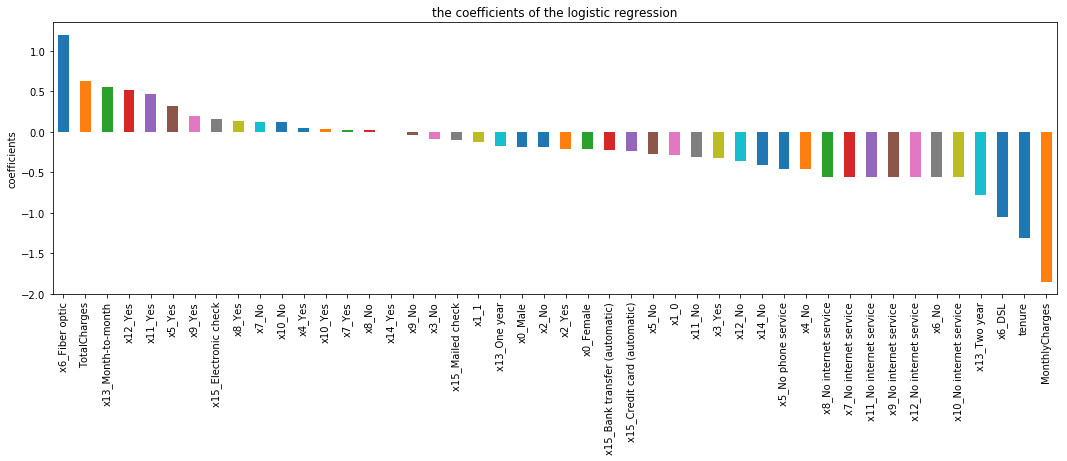

In [52]:
plt.figure(figsize=(18, 5))
lr_coef.plot(kind = 'bar')
_ = plt.title('the coefficients of the logistic regression')
_ = plt.ylabel('coefficients')

### Linear Support Vector Machines

In [53]:
linearSVC_coef = grid_lnearsvc.best_estimator_.named_steps['linearsvc'].coef_
linearSVC_coef = linearSVC_coef.flatten()
linearSVC_coef = pd.Series(linearSVC_coef,index=col_name).sort_values(ascending=False)

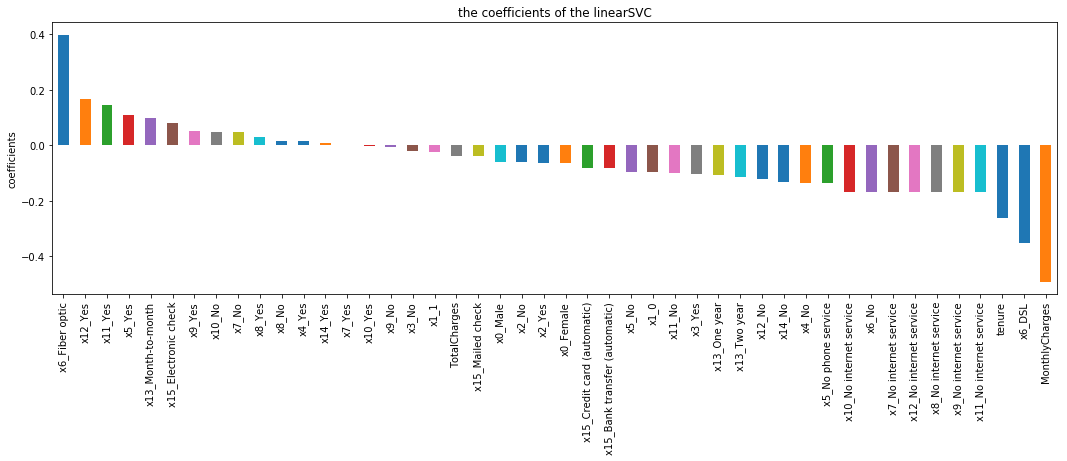

In [54]:
plt.figure(figsize=(18, 5))
linearSVC_coef.plot(kind = 'bar')
_ = plt.title('the coefficients of the linearSVC')
_ = plt.ylabel('coefficients')